这里主要学习如何使用Pytorch自带的VGG-16模型，如果根据需要修改这个模型。  
如何在训练过程中记录和保存最佳模型。如何加载使用保存的模型。  

### 附件：ImageNet竞赛和VGG模型  
2009 年，时任斯坦福大学任助理教授的李飞飞，在CVPR 2009 上发表了一篇名为《ImageNet: A Large-Scale Hierarchical Image Database》的论文。来自全球 167 个国家近 5 万名工作者以众包的方式，通过三年合作努力，标注出 1500 万张图像，最终成为 AI 历史上的有标志性意义的图像数据集。 
2010年开始，李飞飞团队开始了ImageNet大规模视觉识别挑战赛（ILSVRC）。全世界的机器学习开发者可以参加这个比赛，让自己的模型来识别图像并分类，以挑战最高的识别率。   
毫不夸张的说，ImageNet 是图像处理算法的试金石。从 2010 年起，每年 ImageNet 官方会举办挑战赛。2017 年后的比赛由 Kaggle 社区主持。自 2012 年 Hinton 等的团队提出 AlexNet 开始，每年都有层出不穷的模型希望在 ImageNet 排行榜上取得一席之地。图像分类正确率从60%提高到了85%+。

其中VGG-19模型在2014年被提出，当时的准确率达到了75%，是当年的领先水平。目前经历的版本有 VGG11、VGG13、VGG16、VGG19。而 VGG16 网络，一共包含了 13 个卷积层和 3 个全连接层，因此网络的层数一共有 16 层，被称为VGG16。在识别能力和性能之间达到了一个平衡。


**torchvision.models** 中包含了如下模型
AlexNet
VGG
ResNet
SqueezeNet
DenseNet
Inception v3

这些都是历年在Imagenet图像识别比赛中获奖的模型。


## 一、 前期准备
### 1. 设置GPU

In [23]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from torchvision import transforms, datasets
import os,PIL,pathlib,warnings

warnings.filterwarnings("ignore")             #忽略警告信息

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 2. 导入数据

In [33]:
import os,PIL,random,pathlib

data_dir = './04-data/'
data_dir = pathlib.Path(data_dir)

data_paths  = list(data_dir.glob('*'))
classeNames = [str(path).split("\\")[1] for path in data_paths]
classeNames

['Angelina Jolie',
 'Brad Pitt',
 'Denzel Washington',
 'Hugh Jackman',
 'Jennifer Lawrence',
 'Johnny Depp',
 'Kate Winslet',
 'Leonardo DiCaprio',
 'Megan Fox',
 'Natalie Portman',
 'Nicole Kidman',
 'Robert Downey Jr',
 'Sandra Bullock',
 'Scarlett Johansson',
 'Tom Cruise',
 'Tom Hanks',
 'Will Smith']

In [34]:
# 关于transforms.Compose的更多介绍可以参考：https://blog.csdn.net/qq_38251616/article/details/124878863
train_transforms = transforms.Compose([
    transforms.Resize([224, 224]),  # 将输入图片resize成统一尺寸
    # 测试点1：下面这句干了什么？去掉对准确率有什么影响？为什么？
    # transforms.RandomHorizontalFlip(), # 随机水平翻转
    transforms.ToTensor(),          # 将PIL Image或numpy.ndarray转换为tensor，并归一化到[0,1]之间
    transforms.Normalize(           # 标准化处理-->转换为标准正太分布（高斯分布），使模型更容易收敛
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225])  # 其中 mean=[0.485,0.456,0.406]与std=[0.229,0.224,0.225] 从数据集中随机抽样计算得到的。
])

total_data = datasets.ImageFolder("./04-data/",transform=train_transforms)
total_data

Dataset ImageFolder
    Number of datapoints: 1800
    Root location: ./04-data/
    StandardTransform
Transform: Compose(
               Resize(size=[224, 224], interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [35]:
total_data.class_to_idx

{'Angelina Jolie': 0,
 'Brad Pitt': 1,
 'Denzel Washington': 2,
 'Hugh Jackman': 3,
 'Jennifer Lawrence': 4,
 'Johnny Depp': 5,
 'Kate Winslet': 6,
 'Leonardo DiCaprio': 7,
 'Megan Fox': 8,
 'Natalie Portman': 9,
 'Nicole Kidman': 10,
 'Robert Downey Jr': 11,
 'Sandra Bullock': 12,
 'Scarlett Johansson': 13,
 'Tom Cruise': 14,
 'Tom Hanks': 15,
 'Will Smith': 16}

### 3. 划分数据集

In [36]:
train_size = int(0.8 * len(total_data))
test_size  = len(total_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(total_data, [train_size, test_size])
train_dataset, test_dataset

(<torch.utils.data.dataset.Subset at 0x2084c43ef10>,
 <torch.utils.data.dataset.Subset at 0x205bc893bd0>)

In [37]:
batch_size = 32

train_dl = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=1)
test_dl = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1)

In [38]:
for X, y in test_dl:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([32, 3, 224, 224])
Shape of y:  torch.Size([32]) torch.int64


好了，到现在为止，和前面的模型没有太大区别。

## 二、调用官方的VGG-16模型
VGG-16（Visual Geometry Group-16）是由牛津大学视觉几何组（Visual Geometry Group）提出的一种深度卷积神经网络架构，用于图像分类和对象识别任务。VGG-16在2014年被提出，是VGG系列中的一种。VGG-16之所以备受关注，是因为它在ImageNet图像识别竞赛中取得了很好的成绩，展示了其在大规模图像识别任务中的有效性。

**以下是VGG-16的主要特点：** 
**1. 深度：** VGG-16由16个卷积层和3个全连接层组成，因此具有相对较深的网络结构。这种深度有助于网络学习到更加抽象和复杂的特征。   
**2. 卷积层的设计：** VGG-16的卷积层全部采用3x3的卷积核和步长为1的卷积操作，同时在卷积层之后都接有ReLU激活函数。这种设计的好处在于，通过堆叠多个较小的卷积核，可以提高网络的非线性建模能力，同时减少了参数数量，从而降低了过拟合的风险。   
**3. 池化层：** 在卷积层之后，VGG-16使用最大池化层来减少特征图的空间尺寸，帮助提取更加显著的特征并减少计算量。   
**4. 全连接层：** VGG-16在卷积层之后接有3个全连接层，最后一个全连接层输出与类别数相对应的向量，用于进行分类。   

**VGG-16结构说明：** 

● 13个卷积层（Convolutional Layer），分别用blockX_convX表示；  
● 3个全连接层（Fully connected Layer），用classifier表示；  
● 5个池化层（Pool layer）。  

VGG-16包含了16个隐藏层（13个卷积层和3个全连接层），故称为VGG-16  

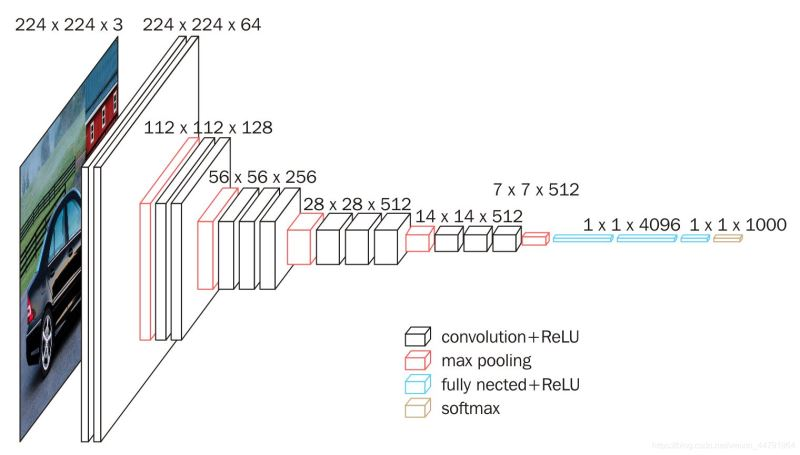

1、一张原始图片被resize到(224,224,3)。
2、conv1两次[3,3]卷积网络，输出的特征层为64，输出为(224,224,64)，再2X2最大池化，输出net为(112,112,64)。  
3、conv2两次[3,3]卷积网络，输出的特征层为128，输出net为(112,112,128)，再2X2最大池化，输出net为(56,56,128)。  
4、conv3三次[3,3]卷积网络，输出的特征层为256，输出net为(56,56,256)，再2X2最大池化，输出net为(28,28,256)。  
5、conv4三次[3,3]卷积网络，输出的特征层为512，输出net为(28,28,512)，再2X2最大池化，输出net为(14,14,512)。  
6、conv5三次[3,3]卷积网络，输出的特征层为512，输出net为(14,14,512)，再2X2最大池化，输出net为(7,7,512)。  
7、利用卷积的方式模拟全连接层，效果等同，输出net为(1,1,4096)。共进行两次。  
8、利用卷积的方式模拟全连接层，效果等同，输出net为(1,1,1000)。  
最后输出的就是每个类的预测。  

In [39]:
from torchvision.models import vgg16

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
    
# 加载预训练模型，并且对模型进行微调
model = vgg16(pretrained = True).to(device) # 加载预训练的vgg16模型

model


Using cuda device


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [41]:
# 测试点2：这里因为只训练最后一层的参数。好处是训练速度会比较快，缺点是可能优化得不是太好，准确率不够高
# 警告：最后再试这个，训练全模型数据，在我的笔记本上基本跑不动
for param in model.parameters():
    param.requires_grad = False # 冻结模型的参数，这样子在训练的时候在这一层使用模型自带的训练好的参数，不需要训练

# 修改classifier模块的第6层（即：(6): Linear(in_features=4096, out_features=2, bias=True)）
# 修改vgg16模型中最后一层全连接层，输出目标类别个数，这一层会参加训练
model.classifier._modules['6'] = nn.Linear(4096,len(classeNames)) 
model.to(device)  

# 注意查看我们下方打印出来的模型，比较和上面模型的区别。
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 三、 训练模型
### 1. 编写训练函数

In [42]:
# 训练循环
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)  # 训练集的大小
    num_batches = len(dataloader)   # 批次数目, (size/batch_size，向上取整)

    train_loss, train_acc = 0, 0  # 初始化训练损失和正确率
    
    for X, y in dataloader:  # 获取图片及其标签
        X, y = X.to(device), y.to(device)
        
        # 计算预测误差
        pred = model(X)          # 网络输出
        loss = loss_fn(pred, y)  # 计算网络输出和真实值之间的差距，targets为真实值，计算二者差值即为损失
        
        # 反向传播
        optimizer.zero_grad()  # grad属性归零
        loss.backward()        # 反向传播
        optimizer.step()       # 每一步自动更新
        
        # 记录acc与loss
        train_acc  += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()
            
    train_acc  /= size
    train_loss /= num_batches

    return train_acc, train_loss

### 2. 编写测试函数

In [43]:
def test (dataloader, model, loss_fn):
    size        = len(dataloader.dataset)  # 测试集的大小
    num_batches = len(dataloader)          # 批次数目, (size/batch_size，向上取整)
    test_loss, test_acc = 0, 0
    
    # 当不进行训练时，停止梯度更新，节省计算内存消耗
    with torch.no_grad():
        for imgs, target in dataloader:
            imgs, target = imgs.to(device), target.to(device)
            
            # 计算loss
            target_pred = model(imgs)
            loss        = loss_fn(target_pred, target)
            
            test_loss += loss.item()
            test_acc  += (target_pred.argmax(1) == target).type(torch.float).sum().item()

    test_acc  /= size
    test_loss /= num_batches

    return test_acc, test_loss

### 3. 设置动态学习率

In [31]:
# 自己调整学习率
# def adjust_learning_rate(optimizer, epoch, start_lr):
#     # 每 2 个epoch衰减到原来的 0.92
#     lr = start_lr * (0.92 ** (epoch // 2))
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = lr

# 测试点3： 可以试试learn rate 0.1，0.01，0.001，一步一步调整找到最优的
# hint：这个一般要跑20-30epoch才能看到效果怎么样，看机器性能了。
learn_rate =  1e-4 # 初始学习率
# optimizer  = torch.optim.SGD(model.parameters(), lr=learn_rate)

# 调用官方动态学习率接口时使用
# 测试点4：同样，这里的动态learn rate是每4个epoch调整为原来的95%，这个也可以试试修改。不调整，或者更快，更慢
lambda1 = lambda epoch: 0.95 ** (epoch // 4)
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1) #选定调整方法

## 4. 正式训练

In [ ]:
import copy
import time

print("Epoch:","Here")
loss_fn    = nn.CrossEntropyLoss() # 创建损失函数
epochs     = 50

train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

best_acc = 0    # 设置一个最佳准确率，作为最佳模型的判别指标
total_acc = 0
time1 = time.time()
for epoch in range(epochs):
    # 更新学习率（使用自定义学习率时使用）
    # adjust_learning_rate(optimizer, epoch, learn_rate)
    
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, optimizer)
    scheduler.step() # 更新学习率（调用官方动态学习率接口时使用）
    
    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)
    
    # 保存最佳模型到 best_model
    if epoch_test_acc > best_acc:
        best_acc   = epoch_test_acc
        best_model = copy.deepcopy(model)   # 保存最佳模型
    
    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    
    # 获取当前的学习率
    lr = optimizer.state_dict()['param_groups'][0]['lr']
    
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%, Test_loss:{:.3f}, Lr:{:.2E}')
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, 
                          epoch_test_acc*100, epoch_test_loss, lr))
    total_acc += epoch_test_acc
    
# 保存最佳模型到文件中
PATH = './best_model.pth'  # 保存的参数文件名
torch.save(model.state_dict(), PATH)
print("Ave acc:", total_acc/epochs*100, "  Best:", best_acc*100,"  Time:", time.time()-time1)
print('Done')

Epoch: Here
Epoch: 1, Train_acc:6.8%, Train_loss:2.884, Test_acc:6.7%, Test_loss:2.837, Lr:8.50E-03
Epoch: 2, Train_acc:6.1%, Train_loss:2.883, Test_acc:6.7%, Test_loss:2.841, Lr:8.50E-03
Epoch: 3, Train_acc:6.7%, Train_loss:2.883, Test_acc:6.7%, Test_loss:2.843, Lr:8.08E-03
Epoch: 4, Train_acc:6.9%, Train_loss:2.902, Test_acc:6.7%, Test_loss:2.842, Lr:8.08E-03
Epoch: 5, Train_acc:7.0%, Train_loss:2.890, Test_acc:6.7%, Test_loss:2.842, Lr:8.08E-03
Epoch: 6, Train_acc:6.7%, Train_loss:2.875, Test_acc:6.7%, Test_loss:2.843, Lr:8.08E-03
Epoch: 7, Train_acc:6.9%, Train_loss:2.895, Test_acc:6.7%, Test_loss:2.850, Lr:7.67E-03


## 四、 结果可视化
### 1. Loss与Accuracy图

In [ ]:
import matplotlib.pyplot as plt
#隐藏警告
import warnings
warnings.filterwarnings("ignore")               #忽略警告信息
plt.rcParams['font.sans-serif']    = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号
plt.rcParams['figure.dpi']         = 100        #分辨率

epochs_range = range(epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 2. 指定图片进行预测

In [ ]:
from PIL import Image 

classes = list(total_data.class_to_idx)

def predict_one_image(image_path, model, transform, classes):
    
    test_img = Image.open(image_path).convert('RGB')
    plt.imshow(test_img)  # 展示预测的图片

    test_img = transform(test_img)
    img = test_img.to(device).unsqueeze(0)
    
    model.eval()
    output = model(img)

    _,pred = torch.max(output,1)
    pred_class = classes[pred]
    print(f'预测结果是：{pred_class}')
    
# 预测训练集中的某张照片
predict_one_image(image_path='./04-data/Angelina Jolie/001_fe3347c0.jpg', 
                  model=model, 
                  transform=train_transforms, 
                  classes=classes)

## 五、 思考练习

如何提高模型的准确率，最高能到多少？

我在PC上（性能好）最后训练集准确率达到了99%+，测试集80%+。